In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from sklearn import metrics

In [3]:
transform = transforms.Compose([
    #transforms.Grayscale(),
    transforms.ToTensor(),
])

traindataset = datasets.STL10('./downloads/', download=True, split='train', transform=transform)
testdataset = datasets.STL10('./downloads/', download=True, split='test', transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(f'traindataset =>{traindataset.data.shape}')
print(f'testdataset =>{testdataset.data.shape}')

traindataset =>(5000, 3, 96, 96)
testdataset =>(8000, 3, 96, 96)


In [5]:

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=100, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000, shuffle=False, num_workers=4)

torch.Size([1000, 3, 96, 96])


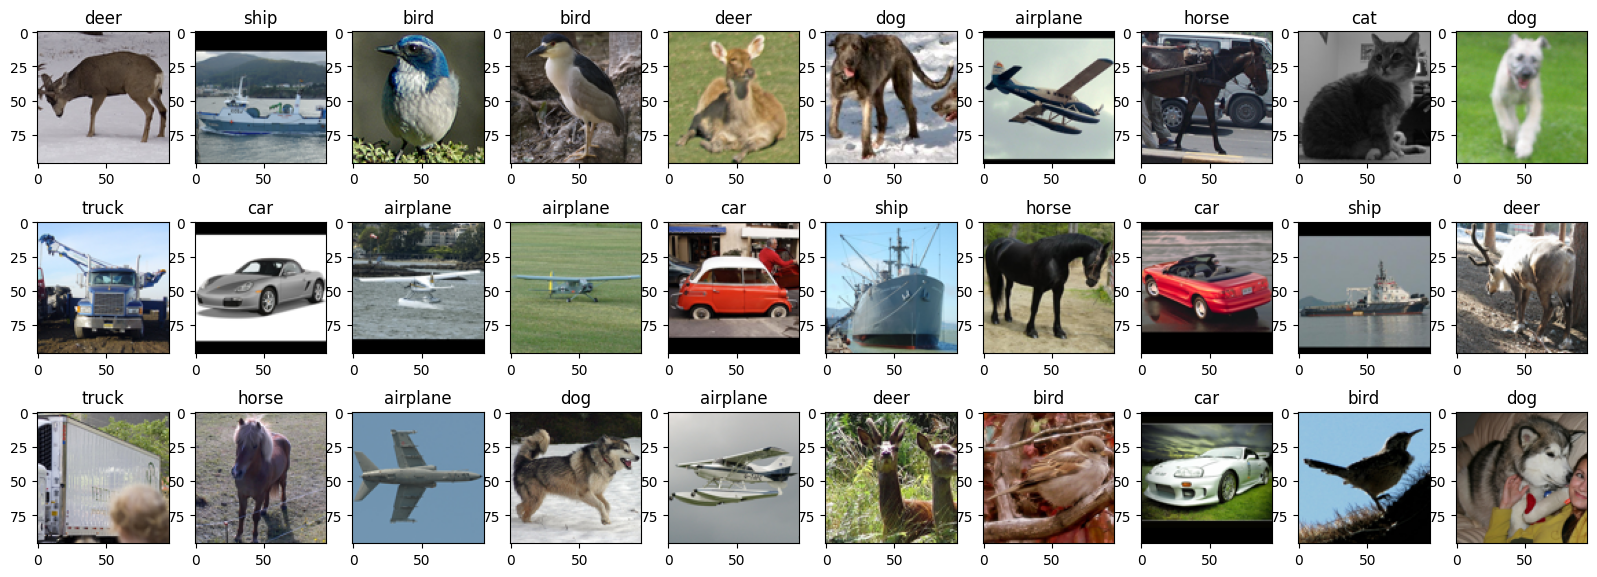

In [6]:
def view_samples():
    
    test_images, labels = next(iter(testloader))
    print(test_images.shape)
    fig = plt.figure(figsize =(20,7))
    nrows = 3
    ncols = 10
    b=np.random.randint(0,test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(testdataset.classes[labels[i+b].cpu().numpy()])
        plot.imshow(np.transpose(test_images[i+b], (1, 2, 0)).cpu())
    plt.show()
view_samples()

In [7]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize =(20,7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:,0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:,2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:,3], linestyle='-', label="Validation Accuracy" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()

In [8]:
# Train the model
def model_training(model,criterion,optimizer,trainloader,testloader,num_epochs = 10):
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*images.size(0)
            train_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            images, labels = next(iter(testloader))
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*images.size(0)
            val_acc += metrics.accuracy_score(labels,outputs.argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        #val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        #val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f},  \tTraining acc: {train_acc:.6f}, \tTest acc: {val_acc:.6f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    
    return np.array(loss_list)


In [31]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred_probs, label):
    Y_pred = Y_pred_probs.argmax(axis=1)
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    top_5_accuracy = metrics.top_k_accuracy_score(Y_test,Y_pred_probs,k=5,labels=np.arange(10))

    plt.figure(figsize=(10, 10))
    plt.title(f'Top 1 Accuracy : {overallAccuracy*100:3.2f}% | Top 5 Accuracy : {top_5_accuracy*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print(f'Top 1 Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'Top 5 Accuracy: {top_5_accuracy*100}%')
    print(f'Classwise Accuracy Score: \n{classwiseAccuracy}')

In [ ]:
selected_optimizers:list[torch.optim.Optimizer] = [torch.optim.Adam,torch.optim.Adagrad,torch.optim.Adadelta,torch.optim.RMSprop]

for optimizer in selected_optimizers:
    print(f'Selected optimizer :{optimizer}')
    # Load the pre-trained ResNet18 model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Replace the final fully connected layer
    num_classes = 10
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    # Define the optimizer and loss function

    optimizer_inst =  optimizer(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    loss_list = model_training(model,criterion,optimizer_inst,trainloader,testloader,num_epochs=10)
    plot_training_graphs(loss_list)
    test_images, test_labels = next(iter(testloader))
    test_output = model(test_images)
    with torch.no_grad():
        confusionMatrixAndAccuracyReport(test_labels,test_output,testdataset.classes)